<div style="color:white;
           display:fill;
           border-radius:5px;
           background-color:#008000;
           font-size:130%;
           font-family:Verdana;
           letter-spacing:0.5px">

<p style="padding: 10px;
              color:white;">
              Visualize percent difference from a selected date
</p>
</div>

**Goal**

To visualize percent difference of 4 stocks from a selected date. This was a Tableau challenge but I wanted to attempt to re-create it in Python.

**Data**

The dataset is available on [data.world](https://data.world/missdataviz/wow22w3-stocks-jan22).

<div class="alert alert-block alert-info" style="background-color: #008000; color: white; border-color: #008000;">✨ Preparing the data</div>

In [77]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
import datetime as dt

Let's read the data, check the first 5 rows and gather basic information about the dataset.

In [78]:
stocks = pd.read_csv('Stocks.csv')
stocks.head()

,Company,Sales,Close,High,Low,Open,Unix Epoch Time,Volume,Date
0,Facebook,166.69,166.69,171.68,128.56,128.99,1546318800,527547900,2019-01-01
1,Facebook,161.45,161.45,172.47,159.59,165.84,1548997200,302243200,2019-02-01
2,Facebook,166.69,166.69,174.30,159.28,162.60,1551416400,387936100,2019-03-01
3,Facebook,193.40,193.40,198.48,167.28,167.83,1554091200,381985300,2019-04-01
4,Facebook,177.47,177.47,196.18,177.16,194.78,1556683200,286821500,2019-05-01


In [79]:
stocks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 152 entries, 0 to 151
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Company          152 non-null    object 
 1   Sales            152 non-null    float64
 2   Close            152 non-null    float64
 3   High             152 non-null    float64
 4   Low              152 non-null    float64
 5   Open             152 non-null    float64
 6   Unix Epoch Time  152 non-null    int64  
 7   Volume           152 non-null    int64  
 8   Date             152 non-null    object 
dtypes: float64(5), int64(2), object(2)
memory usage: 10.8+ KB


Great! There are no missing values but the data still requires some chnages. The first thing I do is to change the column names to lower case, convert `date` column into datetime in Month-Year format, create a new column to use for a later `groupby()` beacuse the grouping column won't be included into the groupby operation. I also create a subset of data. 

In [80]:
# Make column headers lower case
stocks.columns = map(str.lower, stocks.columns)
# Convert object intto datetime
stocks['date'] = pd.to_datetime(stocks['date']).dt.strftime('%b %y')
# Create new 'co' column for later groupby 
stocks['co'] = stocks['company']
# Subset data
stocks = stocks[['co', 'company', 'close', 'date']]

The selected date, to compare percent difference in stock prices, is `Nov 2020`. Now I need to figure out what  was the close value on the selected date (in this case Nov 2020) for each company, and I need this value to be displayed against every row associated to that company. This is why I will create a new dataframe where I group the companies and filter the data to the selected date to obtain the closing prices of that date and after that I will merge the two dataframes. 

In [81]:
# For each company, get the close price for Nov 2020
selected_date = stocks.groupby('co').apply(lambda x: x.iloc[np.where(x['date'] == 'Nov 20')], include_groups=False).reset_index(drop=True)

In [82]:
# Merge the two dataframes and drop the duplicate company column
stocks = pd.merge(stocks, selected_date, on = 'company').drop(['co'], axis = 1)

In [83]:
# Rename the columns to be more concise
stocks = stocks.rename(columns={'close_x': 'close', 'date_x': 'date', 'close_y': 'ref_close', 'date_y': 'ref_date' })

Now I can create a new column that contains the percent difference from the selected date per row.

In [84]:
# Compute percent difference
stocks['diff_perc'] = round((((stocks['close'] - stocks['ref_close']) / stocks['ref_close'])*100),2)

This is to assign colors to each company.

In [85]:
COLORS = [
    '#1ba3c6', # Facebook
    '#d5bb21', # Google
    '#f64971', # Netflix
    '#4f7cba' # Tesla
    ]

<div class="alert alert-block alert-info" style="background-color: #008000; color: white; border-color: #008000;">✨ Seaborn visualization</div>

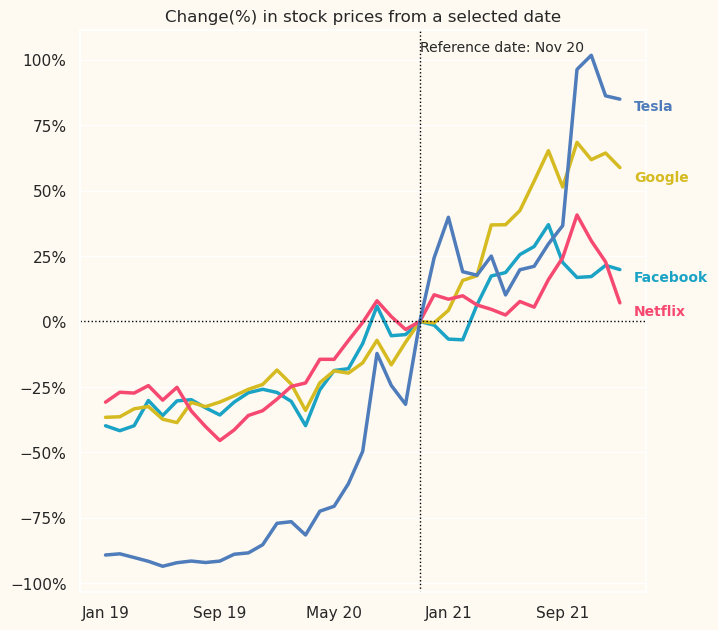

In [86]:
# Define seaborn background colors
sns.set(rc={'axes.facecolor':'#FEFAF1', 'figure.facecolor':'#FEFAF1'})

# Set plot size
plt.figure(figsize=(7.3, 7.3))

# Set figure asthetics
sns.set_context(rc={'lines.linewidth': 2.5})
ax=sns.lineplot(data=stocks, x='date', y='diff_perc', hue='company', palette=COLORS, legend=False)

# Set reference line and its annotation
ax.axvline('Nov 20', ls='dotted', lw=1, color = 'black')
ax.axhline(0, ls='dotted', lw=1, color = 'black')
ax.text('Nov 20', 103, 'Reference date: Nov 20', fontsize=10)

# Set title
ax.set(title = 'Change(%) in stock prices from a selected date')

# Remove axis label
ax.set(xlabel=None)
ax.set(ylabel=None)

# Set annotation
ax.text(37, 82, 'Tesla', color='#4f7cba', fontsize=10, weight='bold', va='center')
ax.text(37, 55, 'Google', color='#d5bb21', fontsize=10, weight='bold', va='center')
ax.text(37, 17, 'Facebook', color='#1ba3c6', fontsize=10, weight='bold', va='center')
ax.text(37, 4, 'Netflix', color='#f64971', fontsize=10, weight='bold', va='center')

# Format axis ticks
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(5))
ax.yaxis.set_major_formatter(mtick.PercentFormatter())

# Remove x gridlines
ax.xaxis.grid(False)

plt.show()

<div class="alert alert-block alert-info" style="background-color: #008000; color: white; border-color: #008000;">✨ Bokeh visualization</div>

In [87]:
from bokeh.plotting import figure, show
from bokeh.models import ColumnDataSource, Label
from bokeh.models import NumeralTickFormatter
from bokeh.models import CustomJSTickFormatter
from bokeh.models import HoverTool, DatetimeTickFormatter
from bokeh.models import CustomJS, DatePicker
from datetime import datetime
from bokeh.io import output_notebook

output_notebook()

Loading BokehJS ...

In [88]:
df = pd.DataFrame(stocks)

# Sort out dates
df['date'] = pd.to_datetime(df['date'], format='%b %y')
df['date_str'] = df['date'].astype('str')

# Create a Bokeh figure
p = figure(width=730, height=730, x_axis_type='datetime')
p.background_fill_color = "#FEFAF1"  # set a background color
p.title.text = "Hover over for more details or click on legend entries to hide the corresponding lines"

# Group data by company
grouped = df.groupby('company')

# Define colors 
colors = COLORS

# Plot lines for each company
for i, (company, group) in enumerate(grouped):
    source = ColumnDataSource(group)
    line1 = p.line(x='date', y='diff_perc', source=source, line_width=2.5, color=colors[i], legend_label=f'{company}')
    line2 = p.line(x='date', y='diff_perc', source=source, line_width=2.5, color=colors[i], legend_label=f'{company}')
    line3 = p.line(x='date', y='diff_perc', source=source, line_width=2.5, color=colors[i], legend_label=f'{company}')
    line4 = p.line(x='date', y='diff_perc', source=source, line_width=2.5, color=colors[i], legend_label=f'{company}')

    # Add HoverTool with customized tooltip
    hover = HoverTool()
    hover.renderers = [line1, line2, line3, line4]
    hover.tooltips = f"""
        <div>
            <span style="font-size: 12px;">The average close for @company on @date_str was $@close which is @diff_perc% from Nov 2020</span><br>            
        </div>
    """
    p.add_tools(hover)

# Add reference lines and annotation
p.hspan(y=[0], line_width=[0.5], line_dash = "dotted", line_color = "black")
p.vspan(x=[1604188800000], line_width=[0.5], line_dash = "dotted", line_color = "black")
p.text(x=[1604188800000], y=[103], text=["Reference Date: Nov 2020"], text_font_size = '12px',
       x_offset=5, y_offset=5, anchor="bottom_left")

# Add legend
p.legend.location = "top_left"
p.legend.click_policy="hide"
p.legend.background_fill_color = "#FEFAF1"
p.legend.border_line_color = None

# Format axis tick labels
p.xaxis.formatter = DatetimeTickFormatter(months="%b %y")
p.yaxis.ticker = [-100, -75, -50, -25, 0, 25, 50, 75, 100]
p.yaxis.minor_tick_line_color = None

# CustomJS code to format ticks as percentages without multiplying by 100
percent_js_code = """
    return tick + '%';
"""
p.yaxis[0].formatter = CustomJSTickFormatter(args={}, code=percent_js_code)

# Format gridlines
p.xgrid.grid_line_color = None
p.ygrid.grid_line_width = 1.5
p.ygrid.grid_line_color = "white"

# Show the plot
show(p)